# Curves frate
Plot average frate as a function of s relative to apex position for each curve and cell.

For each curve we get all the time the mouse goes trough an ROI centered at the curve (or straight segment) apex and 40cm long. 
For each roi crossing, we get the position of the mouse relative to the apex (negative values means before the curve) and and the spikes
of all units as the mouse is crossing the ROI.

Then we show the XY trajectory of the tracking, a raster plot with spikes over position and the mean + sem speed and angular velocity over position.
We also show the mean firing rate per position to get an idea if there's spatial tuning for the units.

In [60]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from fcutils.plot.figure import clean_axes
from fcutils.plot.elements import plot_mean_and_error
from fcutils.maths.signals import rolling_mean
from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts, curves, get_roi_crossings

save_folder = Path(r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys")

# print all available recordings
print(get_recording_names())

['FC_220408_BAA1101192_hairpin' 'FC_220409_BAA1101192_hairpin'
 'FC_220410_BAA1101192_hairpin' 'FC_220411_BAA1101192_hairpin'
 'FC_220412_BAA1101192_hairpin' 'FC_220413_BAA1101192_hairpin'
 'FC_220414_BAA1101192_hairpin' 'FC_220415_BAA1101192_hairpin'
 'FC_220432_BAA1101192_hairpin' 'FC_220433_BAA1101192_hairpin'
 'FC_220434_BAA1101192_hairpin' 'FC_220435_BAA1101192_hairpin']


In [61]:
def frate(spikes, s, bins):
    """
        Given the s position at each frame at the frame at which spikes occurred during a ROI crossing,
        get firing rate wrt position relative to the apex.
    """
    # s = rolling_mean(s, 21)
    n_visits_per_bin, _ = np.histogram(s, bins=bins)

    spikes_positions = [s[spike] for spike in spikes]
    nspikes_per_bin = np.histogram(spikes_positions, bins=bins)[0]


    spikes_positions = rolling_mean(spikes_positions, 5)
    nspikes_per_bin = rolling_mean(nspikes_per_bin, 5)


    frates = nspikes_per_bin / n_visits_per_bin * 60
    frates[np.isnan(frates)] = 0.0
    frates[np.isinf(frates)] = 0.0  # a spike but no frame count?
    return frates

In [79]:
def plot_crossings(axes, crossings, curve, bouts, unit, frate_ax_id, raster_ax_id, color, yshift=0, sign=-1):
    bins = np.arange(-20, 20+4, step=2)
    bins_centers = (bins[1:] + bins[:-1]) / 2

    _frates = {b:[] for b in bins_centers}

    for n, cross in crossings.iterrows():
        s = sign * (curve.s - np.array(bouts.iloc[cross.bout_idx].s[cross.enter_frame:cross.exit_frame]))
        spikes = unit.spikes[(unit.spikes > cross.session_start_frame)&(unit.spikes < cross.session_end_frame)] - cross.session_start_frame
        axes[str(frate_ax_id)].plot(
            s[spikes],
            np.ones_like(spikes)*(n+yshift),
            ".",
            color=color
        )

        cross_frate = rolling_mean(frate(spikes, s, bins), 4)
        # cross_frate = frate(spikes, s, bins)
        for b, fr in zip(bins_centers, cross_frate):
            _frates[b].append(fr)
    

    if len(crossings) > 5:
        frates = np.vstack(list(_frates.values()))
        mean_frate = np.mean(frates, 1)
        sem_frate = np.std(frates, 1) / np.sqrt(len(crossings))
        plot_mean_and_error(
            mean_frate, sem_frate, axes[str(raster_ax_id)], x=bins_centers, color=color
        )


def plot_avg_speed_wrt_s(axes, crossings, bouts, curve, ax_id, color, sign=-1, angvel = False):
    bins = np.arange(-20, 20+2, step=2)
    speeds = {b:[] for b in bins}

    for n, cross in crossings.iterrows():
        bout = bouts.iloc[cross.bout_idx]
        s = sign * (curve.s - np.array(bout.s[cross.enter_frame:cross.exit_frame]))
        s = np.round(s).astype(np.int64)
        # s = rolling_mean(s, 11)

        if angvel:
            speed = rolling_mean(bout.angvel[cross.enter_frame:cross.exit_frame], 11)
        else:
            speed = rolling_mean(bout.speed[cross.enter_frame:cross.exit_frame], 11)
        
        for (_s, S) in zip(s, speed):
            if _s in speeds.keys():
                speeds[_s].append(S)

    mean_speed = [np.mean(v) if len(v) else np.nan for v in speeds.values()]
    sem_speed = np.array([np.std(v) if len(v) else np.nan for v in speeds.values()]) / np.sqrt(len(crossings))

    plot_mean_and_error(
            mean_speed, sem_speed, axes[str(ax_id)], x=bins, color=color
        )


In [106]:
def make_figure(out_bouts, in_bouts, out_crossings, in_crossings, unit):
    fig = plt.figure(figsize=(30, 14))
    axes = fig.subplot_mosaic(
    """
        abcdefg
        hilmnop
        hilmnop
        qrstuvz
        qrstuvz
        1234567
        ABCDEFG
    """
    )

    speeds_axes = "1234567"
    avel_axes = "ABCDEFG"
    xy_axes = "abcdefg"
    avg_frate_axes="hilmnopq"
    raster_axes="qrstuvz"

    color_axes = "bdfimortv246BDF"

    x_shift = [15, 5, 22, 5, 15, 5, 5, ]
    y_shift = [0, 0, 0, 0, 0, 0, 10,]

    for i, curve in enumerate(curves.keys()):
        crossings_out = out_crossings[curve]
        crossings_in = in_crossings[curve]
        axes[xy_axes[i]].set(title=curve)
        curve = curves[curve]

        plot_crossings(axes, crossings_out, curve, out_bouts, unit,raster_axes[i], avg_frate_axes[i], "k", yshift=0, sign=-1)
        plot_crossings(axes, crossings_in, curve, in_bouts, unit,raster_axes[i], avg_frate_axes[i], "r", yshift=len(crossings_out), sign=-1)

        plot_avg_speed_wrt_s(axes, crossings_out, out_bouts, curve, speeds_axes[i], "k", sign=-1)
        plot_avg_speed_wrt_s(axes, crossings_in, in_bouts, curve, speeds_axes[i], "r", sign=-1)
        plot_avg_speed_wrt_s(axes, crossings_out, out_bouts, curve,  avel_axes[i], "k", sign=-1, angvel=True)
        plot_avg_speed_wrt_s(axes, crossings_in, in_bouts, curve, avel_axes[i], "r", sign=-1, angvel=True)

        for n, cross in crossings_out.iterrows():
            bout = out_bouts.iloc[cross.bout_idx]
            axes[xy_axes[i]].scatter(
                (np.array(bout.x[cross.enter_frame:cross.exit_frame]) - x_shift[i]),
                (np.array(bout.y[cross.enter_frame:cross.exit_frame]) - y_shift[i]),
                c=np.arange(cross.exit_frame - cross.enter_frame), cmap="Greys", s=5, vmin=-5, vmax=80
            )

        for n,  cross in crossings_in.iterrows():
            bout = in_bouts.iloc[cross.bout_idx]
            axes[xy_axes[i]].scatter(
                np.array(bout.x[cross.enter_frame:cross.exit_frame]),
                np.array(bout.y[cross.enter_frame:cross.exit_frame]),
                c=np.arange(cross.exit_frame - cross.enter_frame), cmap="Reds", s=5, vmin=-5, vmax=80
            )


    for i, ax in enumerate(avg_frate_axes):
        axes[ax].set(xlim=[-20, 20], xticks=[],  ylabel="frate (Hz)" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)

    for i, ax in enumerate(raster_axes):
        axes[ax].set(xlim=[-20, 20], xticks=[], ylabel="crossing #" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)

    for i, ax in enumerate(speeds_axes):
        axes[ax].set(xlim=[-20, 20], xticks=[], ylim=[10, 80], ylabel="speed (cm/s)" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)
        if i > 0:
            axes[ax].sharey(axes[speeds_axes[0]])
            axes[ax].set(yticks=[])

    axes[speeds_axes[0]].set(ylabel="speed (cm/s)", yticks=[20, 40, 60, 80])


    for i, ax in enumerate(avel_axes):
        axes[ax].set(xlim=[-20, 20], xlabel="delta S (cm)", ylim=[-6, 6], ylabel="ang. vel. (def/s)" if i == 0 else None)
        axes[ax].axvline(0, color="k", lw=2, alpha=.8)
        
        

    for i, ax in enumerate(xy_axes):
        axes[ax].axis("equal")
        axes[ax].axis("off")

    for ax in color_axes:
        axes[ax].set_facecolor([.9, 1, 1])

    clean_axes(fig)
    fig.suptitle(f"{unit.unit_id} - {unit.brain_region}")
    return fig

make a single fig for debugging

In [64]:
REC = "FC_220408_BAA1101192_hairpin"

units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
out_bouts = get_session_bouts(REC, complete=None)
in_bouts = get_session_bouts(REC, direction="inbound", complete=None)

out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

[06/09/22 20:57:25] INFO     Got tracking data for FC_220408_BAA1101192_hairpin  ]8;id=528070;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=528030;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 20:57:26] INFO     Got 44 units for FC_220408_BAA1101192_hairpin       ]8;id=663232;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=673376;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 20:57:27] INFO     Got 41 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=585512;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=341888;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 20:57:28] INFO     Got 40 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=714063;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=837443;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

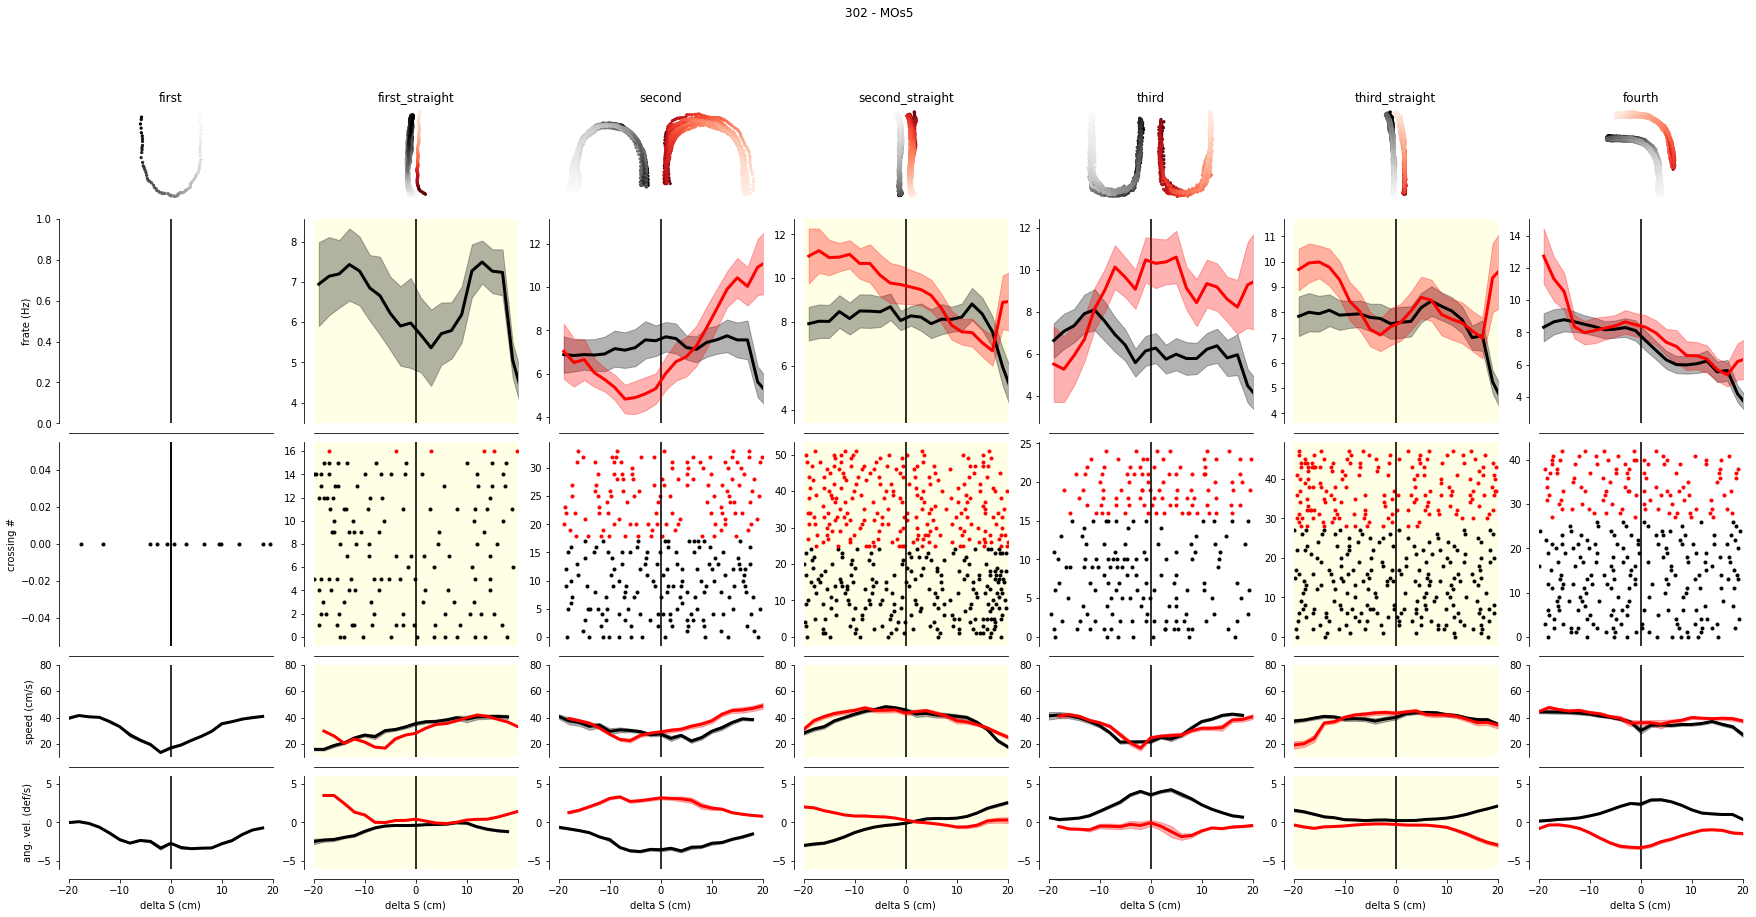

In [105]:
f = make_figure(out_bouts, in_bouts, out_crossings, in_crossings, units.iloc[10])
plt.show(f)

plot all sessions/units

In [107]:
for REC in get_recording_names():
    dest = save_folder / REC / "curves_rasters"
    if dest.exists():
        for f in dest.glob("*"):
            f.unlink()
        dest.rmdir()
    dest.mkdir(exist_ok=True, parents=True)

    units, left_fl, right_fl, left_hl, right_hl, body = get_data(REC)
    if units is None:
        continue

    out_bouts = get_session_bouts(REC, complete=None)
    in_bouts = get_session_bouts(REC, direction="inbound", complete=None)
    out_crossings = {curve:get_roi_crossings(out_bouts, curve, ds=20, direction="out") for curve in curves.keys()}
    in_crossings = {curve:get_roi_crossings(in_bouts, curve, ds=20, direction="in") for curve in curves.keys()}

    for (i, unit) in units.iterrows():
        region = unit.brain_region[:3]
        savepath= dest / f"{region}_{unit.unit_id}.png"
        # if savepath.exists():
        #     continue

        fig = make_figure(out_bouts, in_bouts, out_crossings, in_crossings, unit)
        fig.savefig(savepath, dpi=150, transparent=False, facecolor='w', edgecolor='w')

        # close figure 
        plt.close(fig)
    #     break
    # break
        

[06/09/22 21:26:51] INFO     Got tracking data for FC_220408_BAA1101192_hairpin  ]8;id=793449;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=341145;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 21:26:53] INFO     Got 44 units for FC_220408_BAA1101192_hairpin       ]8;id=235648;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=716398;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 21:26:55] INFO     Got 41 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=280714;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=102507;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 21:26:57] INFO     Got 40 bouts for FC_220408_BAA1101192_hairpin |     ]8;id=483231;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=312026;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 21:37:50] INFO     Got tracking data for FC_220409_BAA1101192_hairpin  ]8;id=712799;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=917663;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

[06/09/22 21:37:52] INFO     Got 44 units for FC_220409_BAA1101192_hairpin       ]8;id=874862;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=807973;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 21:37:53] INFO     Got 48 bouts for FC_220409_BAA1101192_hairpin |     ]8;id=89503;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=753632;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 21:37:55] INFO     Got 49 bouts for FC_220409_BAA1101192_hairpin |     ]8;id=866189;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=363696;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

[06/09/22 21:50:02] INFO     Got tracking data for FC_220410_BAA1101192_hairpin  ]8;id=117682;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=226091;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#169\169]8;;\

                    INFO     Got 40 units for FC_220410_BAA1101192_hairpin       ]8;id=632347;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=436143;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#179\179]8;;\

[06/09/22 21:50:04] INFO     Got 76 bouts for FC_220410_BAA1101192_hairpin |     ]8;id=545678;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=337107;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | outbound

[06/09/22 21:50:06] INFO     Got 65 bouts for FC_220410_BAA1101192_hairpin |     ]8;id=303941;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=273080;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#201\201]8;;\
                             None | inbound

c:\ProgramData\Miniconda3\envs\dev\lib\site-packages\datajoint\connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


OperationalError: (2013, 'Lost connection to MySQL server during query')